In [1]:
import os, sys
import numpy as np 
import sympy as sp 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib import cm
import math
import scipy as sci
from itertools import product 
from scipy.integrate import dblquad

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if os.path.isdir(os.path.join(PROJECT_ROOT, "src")):
    sys.path.insert(0, PROJECT_ROOT)
else:
    # fallback: try current directory
    sys.path.insert(0, os.getcwd())

from numpy.polynomial.legendre import leggauss
from src.basis.basis import BasisHandler
from src.operators import differentiate
from primitives import Primitives_MinimalSupport
from src.matrix_generation import assemble_matrix_integral_1d
from src.solver_utils import solve_precond
from time import time

In [26]:
primitives = Primitives_MinimalSupport()
bh = BasisHandler(primitives=primitives, dimension=2)
bh.build_basis(J_0=2,J_Max=3,comp_call=True)


192
((1, 0), (0, 1))


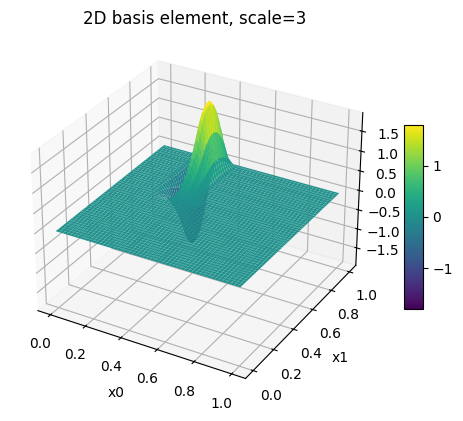

In [16]:
elems = bh.flatten()
print(len(elems))
elem=elems[75]
print(elem["type"])

x_range = np.linspace(0, 1, 200)
x0, x1 = sp.symbols("x0 x1")
f = sp.lambdify((x0, x1), elem["function_sym"](x0, x1), "numpy")
X, Y = np.meshgrid(x_range, x_range)
Z = f(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, linewidth=0, antialiased=True)
ax.set_title(f"2D basis element, scale={elem['scale']}")
ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.set_zlabel("f(x0, x1)")
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.show()

In [6]:



def compute_c_ext(X, Y, s, q_ext=12):
    """
    Compute c_ext(x) = ∫_{R^2  Ω} 1|x-y|^{2+2s} dy
    at quadrature points (X[k],Y[k]) using another Gauss grid
    on a moderately sized box containing Ω.
    """
    # outer box for exterior integration
    L = 4.0     # size; adjust if needed
    g, w = leggauss(q_ext)

    # 1D map [-1,1] → [-L,L]
    t = 0.5 * (g + 1.0)
    y1 = -L + 2*L*t
    wy = 2*L * w * 0.5

    Y1, Y2 = np.meshgrid(y1, y1, indexing="ij")
    Wy = (wy[:, None] * wy[None, :])

    c = np.zeros_like(X)
    for k in range(len(X)):
        x0 = X[k]
        y0 = Y[k]

        dx = x0 - Y1
        dy = y0 - Y2
        R2 = dx*dx + dy*dy

        # mask away Ω
        mask_out = (Y1 < 0) | (Y1 > 1) | (Y2 < 0) | (Y2 > 1)
        R2 = R2[mask_out]
        Wy2 = Wy[mask_out]

        c[k] = np.sum(Wy2 / (R2 ** ((2+2*s)/2.0)))

    return c


def build_fractional_stiffness_matrix(elems, s: float, q: int = 256, q_ext: int = 12):
    """
    Correct integral fractional Laplacian stiffness matrix on Ω = (0,1)^2
    with zero exterior conditions.
    """
    nb = len(elems)

    # quadrature on Ω
    g, w = leggauss(q)
    x1d = 0.5 * (g + 1.0)
    w1d = 0.5 * w

    X2d, Y2d = np.meshgrid(x1d, x1d, indexing="ij")
    Wx2d, Wy2d = np.meshgrid(w1d, w1d, indexing="ij")

    X = X2d.ravel()
    Y = Y2d.ravel()
    W = (Wx2d * Wy2d).ravel()
    Np = X.size

    # compute c_ext at quadrature points
    Cext = compute_c_ext(X, Y, s, q_ext=q_ext)

    # pairwise kernel inside Ω×Ω
    dx = X[:, None] - X[None, :]
    dy = Y[:, None] - Y[None, :]
    R2 = dx*dx + dy*dy

    Wmat = W[:, None] * W[None, :]
    K = np.zeros_like(R2)
    mask = R2 > 0
    K[mask] = Wmat[mask] / (R2[mask] ** ((2+2*s)/2.0))

    # evaluate basis functions
    Phi = np.empty((nb, Np))
    for i, elem in enumerate(elems):
        Phi[i, :] = elem["function_num"](X, Y)

    A = np.zeros((nb, nb))

    # main bilinear form
    for i in range(nb):
        dphi_i = Phi[i][:, None] - Phi[i][None, :]
        for j in range(i, nb):
            dphi_j = Phi[j][:, None] - Phi[j][None, :]
            val = np.sum(dphi_i * dphi_j * K)
            # plus diagonal-like exterior term
            val += np.sum(Phi[i] * Phi[j] * Cext * W)
            A[i, j] = val
            A[j, i] = val

    return A


Stiffness matrix shape: (192, 192)
Sample diagonal entries: [159.08952852  99.22100316  99.25134558 159.23880884  99.22100316]
smallest 10 eigenvalues: [1.98408105 2.62352267 2.62352421 2.97328247 3.37910872 3.37910942
 3.39623633 3.52542253 3.56876191 3.73052018]
min eigenvalue: 1.9840810514862361
max eigenvalue: 243.61320085843172
condition number: 122.78389568608897


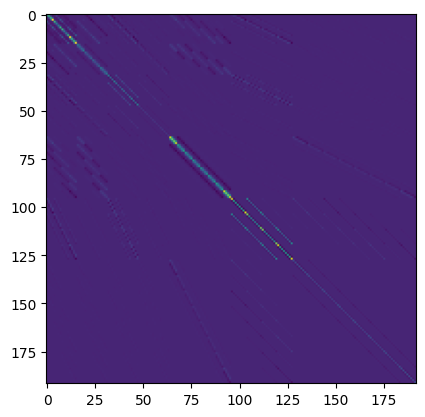

In [17]:
#Stiffnes matrix sanity check 
# elems = list(bh.basis[0].values()) 
elems=bh.flatten()
s = 0.8                             # example
q = 32                               # can try 6–10

S = build_fractional_stiffness_matrix(elems, s=s, q=q)
print("Stiffness matrix shape:", S.shape)
print("Sample diagonal entries:", np.diag(S)[:5])

w = np.linalg.eigvalsh(S)
print("smallest 10 eigenvalues:", w[:10])
print("min eigenvalue:", w[0])
print("max eigenvalue:", w[-1])
print("condition number:", w[-1] / w[0] if w[0] > 0 else np.inf)

plt.imshow(S)
plt.show()

In [31]:
def build_unit_square_quadrature(q: int = 8):
    g, w = leggauss(q)
    x1d = 0.5 * (g + 1.0)
    w1d = 0.5 * w
    X2d, Y2d = np.meshgrid(x1d, x1d, indexing="ij")
    Wx2d, Wy2d = np.meshgrid(w1d, w1d, indexing="ij")
    X = X2d.ravel()
    Y = Y2d.ravel()
    W = (Wx2d * Wy2d).ravel()
    return X, Y, W

def project_function_onto_basis(f_func, elems, q: int = 16):
    """
    True L2 projection:
        find c such that  Σ_j M_{ij} c_j = b_i,
        M_{ij} = ∫ φ_i φ_j,  b_i = ∫ f φ_i.
    """
    X, Y, W = build_unit_square_quadrature(q)
    nb = len(elems)

    # basis values at quadrature nodes
    Phi = np.empty((nb, X.size))
    for i, elem in enumerate(elems):
        Phi[i, :] = elem["function_num"](X, Y)

    # mass matrix M_ij = Σ W φ_i φ_j
    M = np.empty((nb, nb))
    for i in range(nb):
        for j in range(i, nb):
            val = np.sum(Phi[i] * Phi[j] * W)
            M[i, j] = val
            M[j, i] = val

    # right-hand side b_i = ∫ f φ_i
    F = f_func(X, Y)
    b = np.array([np.sum(F * Phi[i] * W) for i in range(nb)])

    # solve M c = b
    c = np.linalg.solve(M, b)
    return c

    return coeffs

def reconstruct_solution(coeffs, elements):
    def u(x, y):
        s = 0.0
        for c, elem in zip(coeffs, elements):
            f = elem["function_num"]
            s += c * f(x, y)
        return s
    return u

def l2_error(u_num, u_ref, n=200):
    """
    Approximate L2 error over (0,1)^2 between two callables u_num, u_ref.
    """
    x = np.linspace(0.0, 1.0, n)
    y = np.linspace(0.0, 1.0, n)
    X, Y = np.meshgrid(x, y, indexing="ij")

    diff = u_num(X, Y) - u_ref(X, Y)
    err_sq = diff**2

    dx = 1.0 / (n - 1)
    dy = 1.0 / (n - 1)
    return np.sqrt(np.sum(err_sq) * dx * dy)

In [32]:
#Sanity check 
def u_target(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)

# your basis
# elems = list(bh.basis[0].values())
elems=bh.flatten()

# projection quadrature order; can match stiffness q
q_proj = 64

u_exact_coeffs = project_function_onto_basis(u_target, elems, q=q_proj)
print("u_exact_coeffs norm:", np.linalg.norm(u_exact_coeffs))

u_exact_fe = reconstruct_solution(u_exact_coeffs, elems)

b = S @ u_exact_coeffs
print("RHS norm:", np.linalg.norm(b))


u_exact_coeffs norm: 0.534760568394431
RHS norm: 33.851737186504046


(192, 192)
192
‖u_num_coeffs‖: 0.5347605683944309
Relative coefficient error: 7.80812542553473e-16
L2 error vs FEM exact: 1.8431662860889896e-16
L2 error vs continuous target: 3.111400219002066e-05


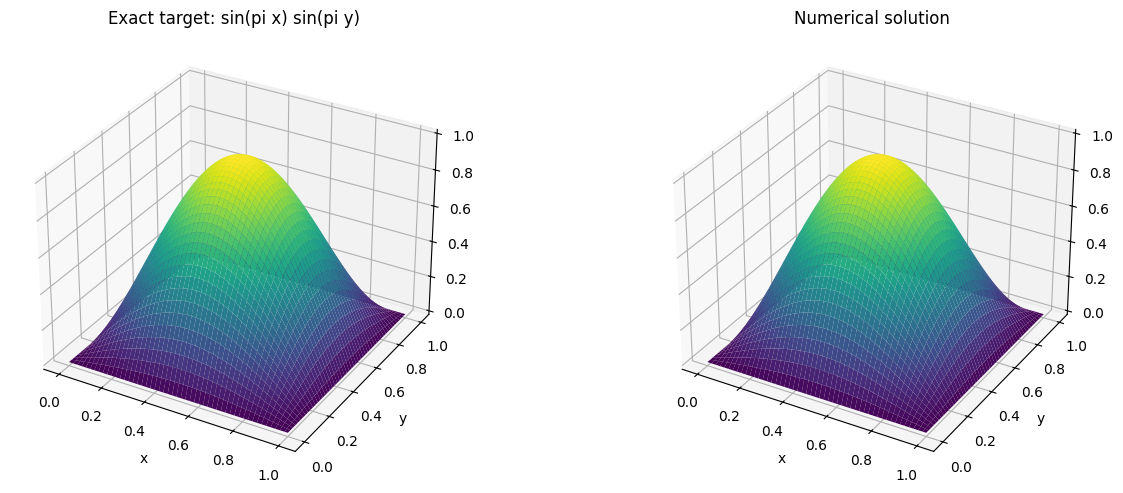

In [33]:
#Test run 1 
# Solve S u = b
print(S.shape)
print(len(elems))
u_num_coeffs = solve_precond(S, b)
print("‖u_num_coeffs‖:", np.linalg.norm(u_num_coeffs))

# Coefficient-space error vs exact FEM coefficients
coeff_err = np.linalg.norm(u_num_coeffs - u_exact_coeffs) / np.linalg.norm(u_exact_coeffs)
print("Relative coefficient error:", coeff_err)

u_num = reconstruct_solution(u_num_coeffs, elems)

# error vs exact FEM solution
l2err_fe = l2_error(u_num, u_exact_fe)
print("L2 error vs FEM exact:", l2err_fe)

# error vs continuous target
l2err_cont = l2_error(u_num, u_target)
print("L2 error vs continuous target:", l2err_cont)

n = 200
xg = np.linspace(0, 1, n)
yg = np.linspace(0, 1, n)
Xg, Yg = np.meshgrid(xg, yg, indexing="ij")

Z_num = u_num(Xg, Yg)
Z_exact = u_target(Xg, Yg)  # or u_exact_fe(Xg, Yg) if you want the FEM version


fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax1.plot_surface(Xg, Yg, Z_exact, cmap=cm.viridis)
ax1.set_title("Exact target: sin(pi x) sin(pi y)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.plot_surface(Xg, Yg, Z_num, cmap=cm.viridis)
ax2.set_title("Numerical solution")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

plt.tight_layout()
plt.show()

In [13]:
elems_ml = bh.flatten()  # full multilevel 2D basis for some J_max, J_0
S_ml = build_fractional_stiffness_matrix(elems_ml, s=0.8, q=32, q_ext=16)
w_ml = np.linalg.eigvalsh(S_ml)
print("min eigenvalue S_ml:", w_ml[0])

w_ml, V_ml = np.linalg.eigh(S_ml)
v0 = V_ml[:, 0]
print("smallest eigenvalue:", w_ml[0])
print("indices with |coeff|>1e-2:", [i for i,c in enumerate(v0) if abs(c)>1e-2])

def u_null(x, y):
    s = 0.0
    for c, elem in zip(v0, elems_ml):
        s += c * elem["function_num"](x, y)
    return s

Xg, Yg = np.meshgrid(np.linspace(0,1,200), np.linspace(0,1,200), indexing="ij")
Z_null = u_null(Xg, Yg)
print("max |Z_null|:", np.max(np.abs(Z_null)))


min eigenvalue S_ml: 2.0059129000039655
smallest eigenvalue: 2.005912900003991
indices with |coeff|>1e-2: [16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 37, 38, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
max |Z_null|: 0.1443769756651071


In [27]:



def u_target(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)

elems = bh.flatten()          # current 2D basis (after your extend_isotropic_tensor fix)
q_proj = 32                   # same order as in stiffness, to avoid quadrature aliasing

u_proj_coeffs = project_function_onto_basis_L2(u_target, elems, q=q_proj)
u_proj = reconstruct_solution(u_proj_coeffs, elems)

err_proj = l2_error(u_proj, u_target)
print("L2 projection error:", err_proj)
print("relative projection error:", err_proj / 0.5)


L2 projection error: 3.459366574073515e-05
relative projection error: 6.91873314814703e-05
